# 7. Prediction PySpark

Follow the following prediction example from the Agile Data Science 2.0 Book: <https://github.com/rjurney/Agile_Data_Code_2>




# Initialize PySpark

First, we use the findspark package to initialize PySpark.

In [4]:
# Initialize PySpark
APP_NAME = "PySpark Lecture"

# If there is no SparkSession, create the environment
try:
    sc and spark
except NameError as e:
  #import findspark
  #findspark.init()
    import pyspark
    import pyspark.sql
    sc = pyspark.SparkContext()
    spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

# Loading and Inspecting Parquet Files

Using the `SparkSession` to load files as `DataFrames` and inspecting their contents...

In [3]:
# Load the parquet file containing flight delay records
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Register the data for Spark SQL
on_time_dataframe.registerTempTable("on_time_performance")

# Check out the columns
on_time_dataframe.columns

# Check out some data
on_time_dataframe\
  .select("FlightDate", "TailNum", "Origin", "Dest", "Carrier", "DepDelay", "ArrDelay")\
  .show()

# Trim the fields and keep the result
trimmed_on_time = on_time_dataframe\
  .select(
    "FlightDate",
    "TailNum",
    "Origin",
    "Dest",
    "Carrier",
    "DepDelay",
    "ArrDelay"
  )

# Sample 0.01% of the data and show
trimmed_on_time.sample(False, 0.0001).show()

+----------+-------+------+----+-------+--------+--------+
|FlightDate|TailNum|Origin|Dest|Carrier|DepDelay|ArrDelay|
+----------+-------+------+----+-------+--------+--------+
|2015-01-01| N001AA|   DFW| MEM|     AA|    -3.0|    -6.0|
|2015-01-01| N001AA|   MEM| DFW|     AA|    -4.0|    -9.0|
|2015-01-01| N002AA|   ORD| DFW|     AA|     0.0|    26.0|
|2015-01-01| N003AA|   DFW| ATL|     AA|   100.0|   112.0|
|2015-01-01| N003AA|   DFW| HDN|     AA|    78.0|    78.0|
|2015-01-01| N003AA|   HDN| DFW|     AA|   332.0|   336.0|
|2015-01-01| N004AA|   JAC| DFW|     AA|    -4.0|    21.0|
|2015-01-01| N005AA|   EGE| ORD|     AA|    null|    null|
|2015-01-01| N005AA|   ORD| EGE|     AA|    null|    null|
|2015-01-01| N005AA|   DFW| ORD|     AA|    null|    null|
|2015-01-01| N006AA|   DFW| ATL|     AA|    null|    null|
|2015-01-01| N006AA|   ATL| DFW|     AA|    -5.0|     1.0|
|2015-01-01| N006AA|   DFW| ATL|     AA|    -4.0|   -11.0|
|2015-01-01| N007AA|   DFW| ATL|     AA|    76.0|    86.

# Calculating Histograms

Using `RDDs` to calculate histograms buckets and values...

In [11]:
# Compute a histogram of departure delays
on_time_dataframe\
  .select("DepDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

([-82.0,
  125.0,
  332.0,
  539.0,
  746.0,
  953.0,
  1160.0,
  1367.0,
  1574.0,
  1781.0,
  1988.0],
 [5623798, 100893, 6404, 1013, 486, 211, 76, 34, 9, 2])

# Visualizing Histograms

Using pyplot to visualize histograms...

/home/hpc/ug201/di57hah/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


<Container object of 13 artists>

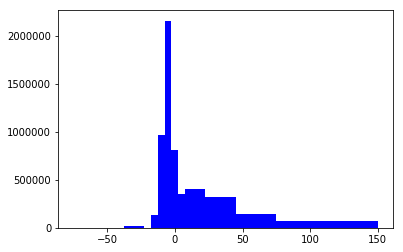

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

# Function to plot a histogram using pyplot
def create_hist(rdd_histogram_data):
    """Given an RDD.histogram, plot a pyplot histogram"""
    heights = np.array(rdd_histogram_data[1])
    full_bins = rdd_histogram_data[0]
    mid_point_bins = full_bins[:-1]
    widths = [abs(i - j) for i, j in zip(full_bins[:-1], full_bins[1:])]
    bar = plt.bar(mid_point_bins, heights, width=widths, color='b')
    return bar

# Compute a histogram of departure delays
departure_delay_histogram = on_time_dataframe\
  .select("DepDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([-60,-30,-15,-10,-5,0,5,10,15,30,60,90,120,180])

create_hist(departure_delay_histogram)

# Counting Airplanes in the US Fleet

In [13]:
# Dump the unneeded fields
tail_numbers = on_time_dataframe.rdd.map(lambda x: x.TailNum)
tail_numbers = tail_numbers.filter(lambda x: x != '')

# distinct() gets us unique tail numbers
unique_tail_numbers = tail_numbers.distinct()

# now we need a count() of unique tail numbers
airplane_count = unique_tail_numbers.count()
print("Total airplanes: {}".format(airplane_count))

Total airplanes: 4898


# Counting the Total Flights Per Month

In [14]:
# Use SQL to look at the total flights by month across 2015
on_time_dataframe.registerTempTable("on_time_dataframe")
total_flights_by_month = spark.sql(
  """SELECT Month, Year, COUNT(*) AS total_flights
  FROM on_time_dataframe
  GROUP BY Year, Month
  ORDER BY Year, Month"""
)

# This map/asDict trick makes the rows print a little prettier. It is optional.
flights_chart_data = total_flights_by_month.rdd.map(lambda row: row.asDict())
flights_chart_data.collect()

[{'Month': u'1', 'Year': u'2015', 'total_flights': 469968},
 {'Month': u'10', 'Year': u'2015', 'total_flights': 486165},
 {'Month': u'11', 'Year': u'2015', 'total_flights': 467972},
 {'Month': u'12', 'Year': u'2015', 'total_flights': 479230},
 {'Month': u'2', 'Year': u'2015', 'total_flights': 429191},
 {'Month': u'3', 'Year': u'2015', 'total_flights': 504312},
 {'Month': u'4', 'Year': u'2015', 'total_flights': 485151},
 {'Month': u'5', 'Year': u'2015', 'total_flights': 496993},
 {'Month': u'6', 'Year': u'2015', 'total_flights': 503897},
 {'Month': u'7', 'Year': u'2015', 'total_flights': 520718},
 {'Month': u'8', 'Year': u'2015', 'total_flights': 510536},
 {'Month': u'9', 'Year': u'2015', 'total_flights': 464946}]

# Using RDDs and Map/Reduce to Prepare a Complex Record

In [15]:
# Filter down to the fields we need to identify and link to a flight
flights = on_time_dataframe.rdd.map(lambda x: 
  (x.Carrier, x.FlightDate, x.FlightNum, x.Origin, x.Dest, x.TailNum)
  )

# Group flights by tail number, sorted by date, then flight number, then origin/dest
flights_per_airplane = flights\
  .map(lambda nameTuple: (nameTuple[5], [nameTuple[0:5]]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'TailNum': tuple[0], 
        'Flights': sorted(tuple[1], key=lambda x: (x[1], x[2], x[3], x[4]))
      }
    )
flights_per_airplane.first()

{'Flights': [(u'US', u'2015-01-01', u'1726', u'EWR', u'CLT'),
  (u'US', u'2015-01-01', u'873', u'CLT', u'ATL'),
  (u'US', u'2015-01-01', u'889', u'ATL', u'CLT'),
  (u'US', u'2015-01-02', u'1781', u'CLT', u'MSY'),
  (u'US', u'2015-01-02', u'1781', u'LGA', u'CLT'),
  (u'US', u'2015-01-02', u'2066', u'CLT', u'LGA'),
  (u'US', u'2015-01-03', u'821', u'MSY', u'CLT'),
  (u'US', u'2015-01-04', u'1700', u'CLT', u'FLL'),
  (u'US', u'2015-01-04', u'1816', u'PHL', u'PIT'),
  (u'US', u'2015-01-04', u'1866', u'FLL', u'CLT'),
  (u'US', u'2015-01-04', u'820', u'CLT', u'PHL'),
  (u'US', u'2015-01-05', u'1896', u'PHL', u'DEN'),
  (u'US', u'2015-01-05', u'1896', u'PIT', u'PHL'),
  (u'US', u'2015-01-05', u'492', u'DEN', u'PHL'),
  (u'US', u'2015-01-05', u'492', u'PHL', u'DFW'),
  (u'US', u'2015-01-06', u'1746', u'DFW', u'PHL'),
  (u'US', u'2015-01-06', u'1790', u'FLL', u'PHL'),
  (u'US', u'2015-01-06', u'2001', u'PHL', u'FLL'),
  (u'US', u'2015-01-07', u'1705', u'PHL', u'PIT'),
  (u'US', u'2015-01-07', u

# Counting Late Flights

In [16]:
total_flights = on_time_dataframe.count()

# Flights that were late leaving...
late_departures = on_time_dataframe.filter(
  on_time_dataframe.DepDelayMinutes > 0
)
total_late_departures = late_departures.count()
print(total_late_departures)

# Flights that were late arriving...
late_arrivals = on_time_dataframe.filter(
  on_time_dataframe.ArrDelayMinutes > 0
)
total_late_arrivals = late_arrivals.count()
print(total_late_arrivals)

# Get the percentage of flights that are late, rounded to 1 decimal place
pct_late = round((total_late_arrivals / (total_flights * 1.0)) * 100, 1)

2125618
2086896


# Counting Flights with Hero Captains

"Hero Captains" are those that depart late but make up time in the air and arrive on time or early.

In [17]:
# Flights that left late but made up time to arrive on time...
on_time_heros = on_time_dataframe.filter(
  (on_time_dataframe.DepDelayMinutes > 0)
  &
  (on_time_dataframe.ArrDelayMinutes <= 0)
)
total_on_time_heros = on_time_heros.count()
print(total_on_time_heros)

606902


# Printing Our Results

In [18]:
print("Total flights:   {:,}".format(total_flights))
print("Late departures: {:,}".format(total_late_departures))
print("Late arrivals:   {:,}".format(total_late_arrivals))
print("Recoveries:      {:,}".format(total_on_time_heros))
print("Percentage Late: {}%".format(pct_late))

Total flights:   5,819,079
Late departures: 2,125,618
Late arrivals:   2,086,896
Recoveries:      606,902
Percentage Late: 35.9%


# Computing the Average Lateness Per Flights

In [19]:
# Get the average minutes late departing and arriving
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
"""
).show()

+-----------+-----------+
|AvgDepDelay|AvgArrDelay|
+-----------+-----------+
|        9.4|        4.4|
+-----------+-----------+



# Inspecting Late Flights

In [20]:
# Why are flights late? Lets look at some delayed flights and the delay causes
late_flights = spark.sql("""
SELECT
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")
late_flights.sample(False, 0.01).show()

+---------------+------------+------------+--------+-------------+-----------------+
|ArrDelayMinutes|WeatherDelay|CarrierDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------------+------------+------------+--------+-------------+-----------------+
|           36.0|         0.0|         0.0|    36.0|          0.0|              0.0|
|           15.0|         5.0|         0.0|     0.0|          0.0|             10.0|
|           32.0|         0.0|         8.0|    24.0|          0.0|              0.0|
|           95.0|        10.0|         0.0|    85.0|          0.0|              0.0|
|           43.0|         0.0|        43.0|     0.0|          0.0|              0.0|
|           40.0|         0.0|         6.0|     7.0|          0.0|             27.0|
|           16.0|         0.0|         8.0|     8.0|          0.0|              0.0|
|           72.0|         4.0|         0.0|    18.0|          0.0|             50.0|
|           69.0|         0.0|         0.0|    13.0|          0.0

# Determining Why Flights Are Late

In [21]:
# Calculate the percentage contribution to delay for each source
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

+-----------------+-----------------+-------------+------------------+-----------------------+
|pct_weather_delay|pct_carrier_delay|pct_nas_delay|pct_security_delay|pct_late_aircraft_delay|
+-----------------+-----------------+-------------+------------------+-----------------------+
|              4.5|             29.2|         20.7|               0.1|                   36.1|
+-----------------+-----------------+-------------+------------------+-----------------------+



# Computing a Histogram of Weather Delayed Flights

In [22]:
# Eyeball the first to define our buckets
weather_delay_histogram = on_time_dataframe\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

([1, 5, 10, 15, 30, 60, 120, 240, 480, 720, 1440.0], [5436, 7668, 6636, 16007, 13569, 9442, 4598, 1136, 152, 72])


<Container object of 10 artists>

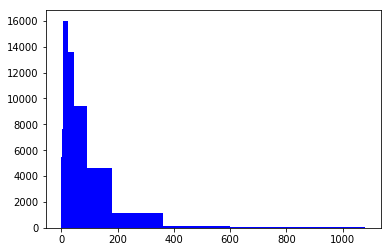

In [23]:
create_hist(weather_delay_histogram)

# Preparing a Histogram for Visualization by d3.js

In [ ]:
# Transform the data into something easily consumed by d3
def histogram_to_publishable(histogram):
  record = {'key': 1, 'data': []}
  for label, value in zip(histogram[0], histogram[1]):
    record['data'].append(
      {
        'label': label,
        'value': value
      }
    )
  return record

# Recompute the weather histogram with a filter for on-time flights
weather_delay_histogram = on_time_dataframe\
  .filter(
    (on_time_dataframe.WeatherDelay != None)
    &
    (on_time_dataframe.WeatherDelay > 0)
  )\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([0, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

record = histogram_to_publishable(weather_delay_histogram)
record

# Building a Classifier Model to Predict Flight Delays

## Loading Our Data

In [31]:
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.jsonl.bz2",
  schema=schema
)
features.first()

Row(ArrDelay=13.0, CRSArrTime=datetime.datetime(2015, 1, 1, 10, 10), CRSDepTime=datetime.datetime(2015, 1, 1, 7, 30), Carrier='AA', DayOfMonth=1, DayOfWeek=4, DayOfYear=1, DepDelay=14.0, Dest='DFW', Distance=569.0, FlightDate=datetime.date(2014, 12, 31), FlightNum='1024', Origin='ABQ')

## Check Data for Nulls

In [32]:
#
# Check for nulls in features before using Spark ML
#
null_counts = [(column, features.where(features[column].isNull()).count()) for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

[]


## Add a Route Column

Demonstrating the addition of a feature to our model...

In [33]:
#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat

features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

+------+----+-------+
|Origin|Dest|  Route|
+------+----+-------+
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
+------+----+-------+
only showing top 5 rows



## Bucketizing ArrDelay into ArrDelayBucket

In [34]:
#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show()

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|           2.0|
|     1.0|           2.0|
|   -29.0|           0.0|
|   -10.0|           1.0|
|    -3.0|           1.0|
|    -8.0|           1.0|
|    -1.0|           1.0|
|   -14.0|           1.0|
|   -16.0|           0.0|
|    18.0|           2.0|
+--------+--------------+
only showing top 20 rows



## Indexing Our String Fields into Numeric Fields

In [35]:
#
# Extract features tools in with pyspark.ml.feature
#
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Turn category fields into categoric feature vectors, then drop intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                          .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|          2.0|            25.0|         

## Combining Numeric Fields into a Single Vector

In [36]:
# Handle continuous, numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+
|    13.0|2015-01-01 10:10:...|2015-01-01 07:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,2.0,2...|
|    17.0|2015-01-01 02:15:...|2014-12-31 23:25:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1184|   ABQ|ABQ-DFW|           2.0|[14.0,569.0,2.0,2...|
|    36.0|2015-01-01 03:45:...|2015-01-01 01:00:...|     AA|     

## Training Our Model in an Experimental Setup

In [37]:
#
# Cross validate, train and evaluate classifier
#

# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.7, 0.3])

# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024
)
model = rfc.fit(training_data)

# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="ArrDelayBucket", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

# Check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

Accuracy = 0.5965632172973679
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|   -11.0|2014-12-31 22:13:...|2014-12-31 21:10:...|     AA|         1|        4|        1|    -3.0| MIA|   192.0|2014-12-31|     1323|   MCO|MCO-MIA|           1.0|[-3.0,192.0,2.0,2...|[3.15496188966384...|[0.15774809448319...|       1.0|
|    -3.0|